In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from scipy.stats import skew

import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

In [2]:
train_df = pd.read_csv("train.csv",parse_dates=["date"])
test_df = pd.read_csv("test.csv",parse_dates=["date"])

In [3]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [4]:
test_df.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [5]:
train_df.dropna(axis=0,inplace=True)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        221259 non-null  int64         
 1   date      221259 non-null  datetime64[ns]
 2   country   221259 non-null  object        
 3   store     221259 non-null  object        
 4   product   221259 non-null  object        
 5   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 11.8+ MB


In [7]:
train_df.isna().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       98550 non-null  int64         
 1   date     98550 non-null  datetime64[ns]
 2   country  98550 non-null  object        
 3   store    98550 non-null  object        
 4   product  98550 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.8+ MB


In [9]:
test_df.isna().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

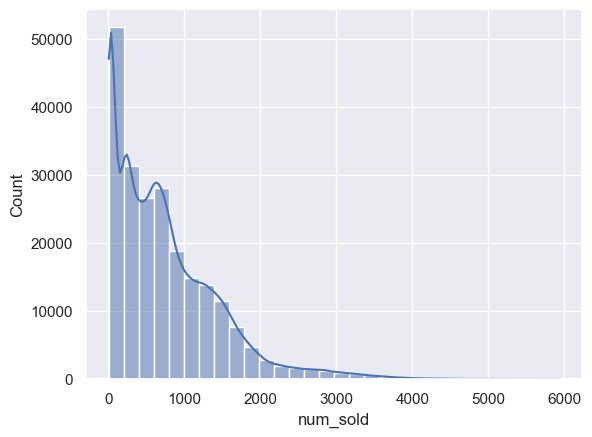

In [10]:
sns.histplot(train_df["num_sold"],bins=30,kde=True)
plt.show()

In [11]:
print(f"Sqrt Transformed Skewness:{skew(np.sqrt(train_df['num_sold']))}")

Sqrt Transformed Skewness:0.17779117637863587


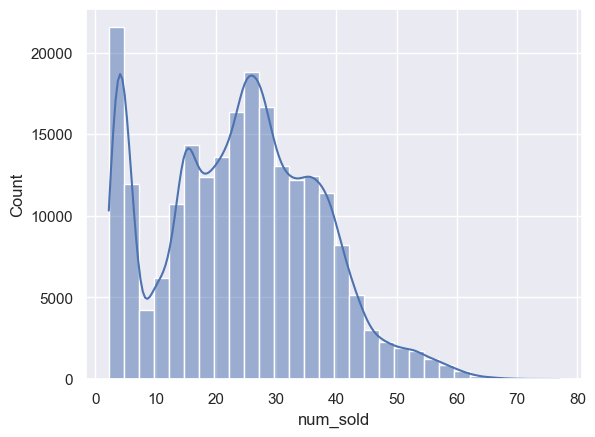

In [12]:
sns.histplot(np.sqrt(train_df["num_sold"]),bins=30,kde=True)
plt.show()

In [13]:
train_df["num_sold"] = np.sqrt(train_df["num_sold"])

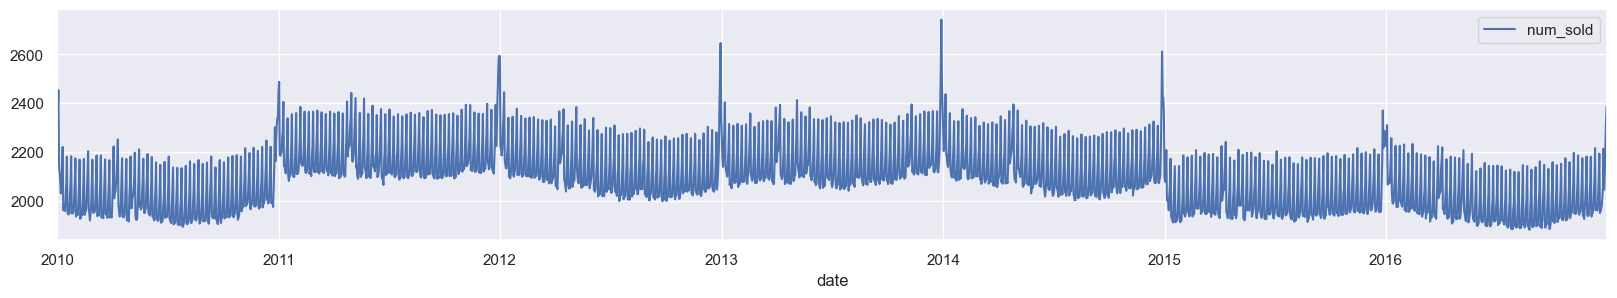

In [14]:
train_df.groupby(["date"])["num_sold"].sum().to_frame().plot(figsize=(20,3))
plt.show()

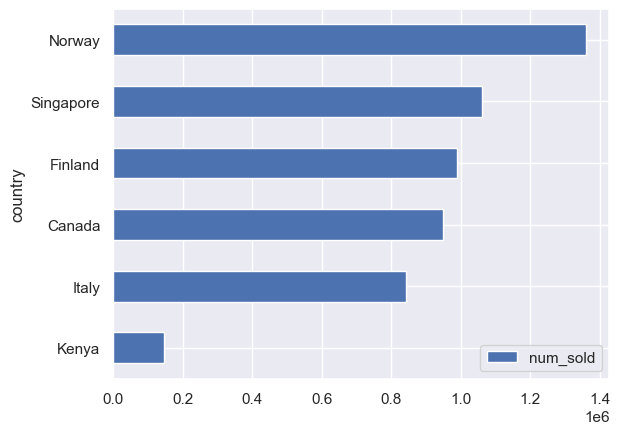

In [15]:
train_df.groupby(["country"])["num_sold"].sum().to_frame().sort_values(by="num_sold").plot(kind="barh")
plt.legend(loc="lower right")
plt.show()

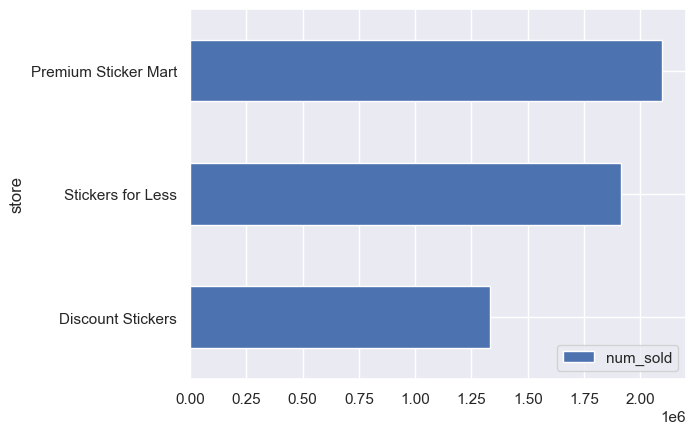

In [16]:
train_df.groupby(["store"])["num_sold"].sum().to_frame().sort_values(by="num_sold").plot(kind="barh")
plt.show()

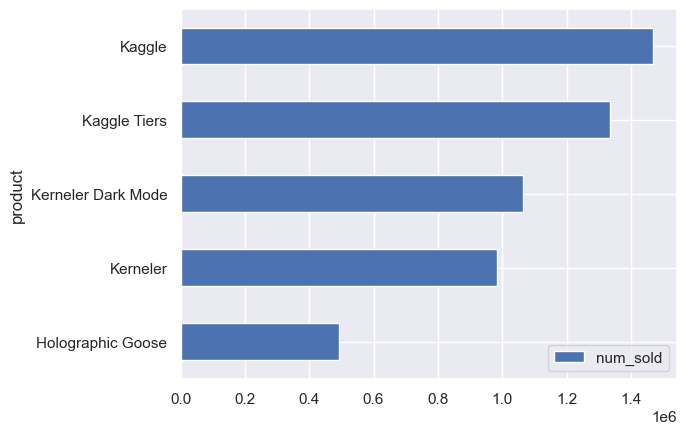

In [17]:
train_df.groupby(["product"])["num_sold"].sum().to_frame().sort_values(by="num_sold").plot(kind="barh")
plt.show()

In [18]:
def preprocess(df:pd.DataFrame):
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_year"] = df["date"].dt.dayofyear

    df['quarter'] = df["date"].dt.quarter
    df['week_of_month'] = df["date"].dt.day.apply(lambda x: (x-1)//7 + 1)
    df['week_of_year'] = df["date"].dt.isocalendar().week
    df['is_weekend'] = df["date"].dt.dayofweek.isin([5,6]).astype(int)
    df['is_month_end'] = df["date"].dt.is_month_end.astype(int)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365)

    return df

In [19]:
train_df = preprocess(df=train_df)

In [20]:
test_df = preprocess(df=test_df)

In [21]:
train_df.set_index("date",inplace=True)
train_df.drop(labels="id",axis=1,inplace=True)
train_df.head()

,country,store,product,num_sold,year,month,day,day_of_week,day_of_year,quarter,week_of_month,week_of_year,is_weekend,is_month_end,month_sin,month_cos,day_sin,day_cos
date,,,,,,,,,,,,,,,,,,
2010-01-01,Canada,Discount Stickers,Kaggle,31.192948,2010,1,1,4,1,1,1,53,0,0,0.5,0.866025,0.017213,0.999852
2010-01-01,Canada,Discount Stickers,Kaggle Tiers,30.099834,2010,1,1,4,1,1,1,53,0,0,0.5,0.866025,0.017213,0.999852
2010-01-01,Canada,Discount Stickers,Kerneler,20.566964,2010,1,1,4,1,1,1,53,0,0,0.5,0.866025,0.017213,0.999852
2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,22.158520,2010,1,1,4,1,1,1,53,0,0,0.5,0.866025,0.017213,0.999852
2010-01-01,Canada,Stickers for Less,Holographic Goose,17.320508,2010,1,1,4,1,1,1,53,0,0,0.5,0.866025,0.017213,0.999852


In [22]:
test_df.set_index("date",inplace=True)
test_df.drop(labels="id",axis=1,inplace=True)
test_df.head()

,country,store,product,year,month,day,day_of_week,day_of_year,quarter,week_of_month,week_of_year,is_weekend,is_month_end,month_sin,month_cos,day_sin,day_cos
date,,,,,,,,,,,,,,,,,
2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1,1,6,1,1,1,52,1,0,0.5,0.866025,0.017213,0.999852
2017-01-01,Canada,Discount Stickers,Kaggle,2017,1,1,6,1,1,1,52,1,0,0.5,0.866025,0.017213,0.999852
2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1,1,6,1,1,1,52,1,0,0.5,0.866025,0.017213,0.999852
2017-01-01,Canada,Discount Stickers,Kerneler,2017,1,1,6,1,1,1,52,1,0,0.5,0.866025,0.017213,0.999852
2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,1,6,1,1,1,52,1,0,0.5,0.866025,0.017213,0.999852


In [23]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [24]:
categoric_columns = train_df.select_dtypes(include="object").columns.to_list()
categoric_columns

['country', 'store', 'product']

In [25]:
LE = {col:LabelEncoder() for col in categoric_columns}
LE

{'country': LabelEncoder(), 'store': LabelEncoder(), 'product': LabelEncoder()}

In [26]:
X,y = train_df.drop(labels="num_sold",axis=1), train_df["num_sold"]

In [27]:
for col in categoric_columns:
    X[col] = LE[col].fit_transform(X[col])
    test_df[col] = LE[col].transform(test_df[col])

In [28]:
tscv = TimeSeriesSplit(n_splits=5,
                       gap=30)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8)

In [30]:
def objective(trial:optuna.Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    }

    model = LGBMRegressor(**params,verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_percentage_error(y_test, y_pred)
    return mae

# Optuna çalıştırma
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# En iyi hiperparametrelerle LightGBM modeli eğitme
best_params = study.best_params
print("Best parameters:", best_params)

[I 2025-01-15 02:56:02,667] A new study created in memory with name: no-name-a146fa86-8ca7-40bb-a1d0-a7dec8795c5a
[I 2025-01-15 02:56:03,680] Trial 0 finished with value: 0.029219468235002034 and parameters: {'n_estimators': 290, 'learning_rate': 0.0816950514647542, 'max_depth': 12, 'num_leaves': 29, 'min_child_samples': 50, 'subsample': 0.676613144758909, 'colsample_bytree': 0.7361995997435984}. Best is trial 0 with value: 0.029219468235002034.
[I 2025-01-15 02:56:06,929] Trial 1 finished with value: 0.02305225803917037 and parameters: {'n_estimators': 953, 'learning_rate': 0.06310232712831226, 'max_depth': 13, 'num_leaves': 74, 'min_child_samples': 21, 'subsample': 0.9846425412470756, 'colsample_bytree': 0.89160720128253}. Best is trial 1 with value: 0.02305225803917037.
[I 2025-01-15 02:56:10,672] Trial 2 finished with value: 0.037472577269438104 and parameters: {'n_estimators': 967, 'learning_rate': 0.01282972641840991, 'max_depth': 6, 'num_leaves': 99, 'min_child_samples': 33, 'su

Best parameters: {'n_estimators': 953, 'learning_rate': 0.06310232712831226, 'max_depth': 13, 'num_leaves': 74, 'min_child_samples': 21, 'subsample': 0.9846425412470756, 'colsample_bytree': 0.89160720128253}


In [31]:
best_params

{'n_estimators': 953,
 'learning_rate': 0.06310232712831226,
 'max_depth': 13,
 'num_leaves': 74,
 'min_child_samples': 21,
 'subsample': 0.9846425412470756,
 'colsample_bytree': 0.89160720128253}

In [32]:
mape_scores = []
lgmb_test_scores = []

for i,(train_index, test_index) in enumerate(tscv.split(X.index)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgbm = LGBMRegressor(**best_params,verbose=-1)
    

    lgbm.fit(X_train,y_train)
    
    prediction = lgbm.predict(X_test)
    mape = mean_absolute_percentage_error(y_test,prediction)

    print(f"Fold {i+1} :")
    print(f"MAPE : {mape}")
    mape_scores.append(mape)

    lgbm_test_prediction = lgbm.predict(test_df)
    lgmb_test_scores.append(lgbm_test_prediction)

print(f"Average MAPE : {np.mean(mape_scores)}")

Fold 1 :
MAPE : 0.04162163538363767
Fold 2 :
MAPE : 0.03667565756994915
Fold 3 :
MAPE : 0.03690402084320982
Fold 4 :
MAPE : 0.05493564267624821
Fold 5 :
MAPE : 0.03414066007654312
Average MAPE : 0.04085552330991759


In [33]:
submission_df = pd.read_csv("sample_submission.csv")
submission_df.head()

,id,num_sold
0,230130,100
1,230131,100
2,230132,100
3,230133,100
4,230134,100


In [34]:
submission_df["num_sold"] = np.mean(lgmb_test_scores,axis=0)**2
submission_df.head()

,id,num_sold
0,230130,174.283175
1,230131,1015.764896
2,230132,852.364564
3,230133,450.095450
4,230134,530.938632
